# Фаза 2 • Неделя 8 • Понедельник
## Нейронные сети
### 🔥 PyTorch

In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import torchutils as tu

import matplotlib.pyplot as plt
import mplcyberpunk
plt.style.use("cyberpunk")

torch.manual_seed(42)


### Оценка стоимости недвижимости с применением нейронных сетей

Загрузите датасет House Prices (https://www.kaggle.com/c/house-prices-advanced-regression-techniques) с прошлой недели: датасет должен быть предобработанный:

* в нем должны отсутствовать пропуски
* данные **обязательно** должны быть нормализованы
* целевая переменная должна быть логарифмирована
* в `TensorDataset` передаем только массив, а не `DataFrame` 

In [2]:
df = pd.read_csv('preprocessed_train.csv')
df

,LotArea,Neighborhood,OverallQual,OverallCond,YearBuilt,TotalBsmtSF,GrLivArea,KitchenQual,SalePrice
0,-0.108804,0.631685,0.775874,-0.805535,0.962201,-0.485504,0.509267,0.903493,12.247699
1,0.130402,0.997491,0.149165,1.914308,0.002198,0.639720,-0.619062,-0.958490,12.109016
2,0.425242,0.631685,0.775874,-0.805535,0.907170,-0.216039,0.625561,0.903493,12.317171
3,0.120650,0.762871,0.775874,-0.805535,0.000000,-1.103170,0.520480,0.903493,11.849405
4,0.861720,1.509488,1.170942,-0.805535,0.878962,0.413265,1.108945,0.903493,12.429220
...,...,...,...,...,...,...,...,...,...
1455,-0.231737,0.572376,0.149165,-0.805535,0.850272,-0.098764,0.403146,-0.958490,12.072547
1456,0.716535,0.525373,0.149165,0.711725,0.095539,1.047321,0.982365,-0.958490,12.254868
1457,0.018381,0.762871,0.775874,2.273577,0.000000,0.428171,1.237733,0.903493,12.493133
1458,0.153014,-0.357778,-1.494169,0.711725,-2.284761,0.259646,-1.928025,0.903493,11.864469


In [3]:
X, y = df.iloc[:, :-1].values, df.iloc[:, -1].values
n_features = X.shape[-1]

1. С использованием библиотеки `pytorch` задай нейронную сеть по следующей схеме: 
    * На первом слое 128 нейронов с активацией `relu`
    * На втором слое 64 нейрона с активацией `relu`
    * На третьем слое дропаут с аргументом 0.5
    * Выходной слой из 1 нейрона

![](aux/baseline.png)

In [4]:
model = nn.Sequential(
    nn.Linear(n_features, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(64, 1)
)

2. Вызови `tu.get_model_summary` модели

In [5]:
tu.get_model_summary(model, torch.randn(1490, n_features))

Layer    Kernel       Output      Params        FLOPs
0_0      [8, 128]   [1490, 128]    1,152    2,860,800
1_1             -   [1490, 128]        0            0
2_2     [128, 64]    [1490, 64]    8,256   24,316,800
3_3             -    [1490, 64]        0            0
4_4             -    [1490, 64]        0            0
5_5       [64, 1]     [1490, 1]       65      189,230
Total params: 9,473
Trainable params: 9,473
Non-trainable params: 0
Total FLOPs: 27,366,830 / 27.37 MFLOPs
-----------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 5.10
Params size (MB): 0.04
Estimated Total Size (MB): 5.19


3. Импортируй `TensorDataset` и `DataLoader` и создай датасет для обучения модели. 

In [6]:
dataset = TensorDataset(torch.tensor(X, dtype=torch.float), torch.tensor(y, dtype=torch.float))
train_ds, valid_ds = random_split(dataset, lengths=(.8, .2))

train_loader = DataLoader(train_ds, shuffle=True, batch_size=146)
valid_loader = DataLoader(valid_ds, shuffle=True, batch_size=146)

4. Создай оптимизатор и задай функцию потерь (она не может быть той же, что и в демо-файле)

In [7]:
optimizer = optim.SGD(model.parameters(), lr=0.04)
criterion = nn.MSELoss()

5. Запусти обучение на 10 эпох и нарисуй кривые обучения и кривые изменения метрик. Не забудь переводить модель в режимы `train` и `eval`. 
    Не забудь о том, что метрика на этот раз должна быть регрессионной, а не классификационной (как в демо файле). 

In [8]:
def plot_loss_metrics(tl: list, vl: list, tm: list, vm: list):
    _, ax = plt.subplots(1, 2, figsize=(14, 5))
    ax[0].plot(tl, label='Train loss')
    ax[0].plot(vl, label='Valid Loss')
    ax[0].legend()
    ax[0].set_title('Loss')
    ax[0].set_ylim((0, max(tl+vl)+.1))

    ax[1].plot(tm, label='Train R²')
    ax[1].plot(vm, label='Valid R²')
    ax[1].legend()
    ax[1].set_title('R²')
    ax[1].set_ylim((0, max(tm+vm)+.1))

In [9]:
def r2_score(y_true, y_pred):
    mean_true = torch.mean(y_true)
    
    ss_total = torch.sum((y_true - mean_true) ** 2)
    ss_residual = torch.sum((y_true - y_pred) ** 2)
    
    r2 = 1 - (ss_residual / ss_total)
    return r2

In [10]:
def fit_model(model: torch.nn.modules.container.Sequential, n_epochs: int) -> tuple:
    train_losses = []
    valid_losses = []

    train_metrics = []
    valid_metrics = []

    for epoch in range(n_epochs):
        model.train()

        train_loss_iter = []
        train_metric_iter = []

        for samples, labels in train_loader:

            predictions = model(samples)
            predictions = predictions.squeeze(-1)

            loss = criterion(predictions, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss_iter.append(loss.item())

            r2 = r2_score(labels, predictions)
            train_metric_iter.append(r2.item())

        model.eval()

        valid_loss_iter = []
        valid_metric_iter = []

        for samples, labels in valid_loader:

            with torch.inference_mode():
                predictions = model(samples)

            predictions = predictions.squeeze(-1)

            loss = criterion(predictions, labels)

            valid_loss_iter.append(loss.item())

            r2 = r2_score(labels, predictions)
            valid_metric_iter.append(r2.item())

        train_losses.append(np.mean(train_loss_iter))
        valid_losses.append(np.mean(valid_loss_iter))

        train_metrics.append(np.mean(train_metric_iter))
        valid_metrics.append(np.mean(valid_metric_iter))

        if epoch % 1 == 0:
            print(f'Epoch {epoch} finished: train_loss={train_losses[-1]:.3f}, valid_loss={valid_losses[-1]:.3f}')
            print(f'Epoch {epoch} finished: train_metric={train_metrics[-1]:.3f}, valid_metric={valid_metrics[-1]:.3f}')


    return train_losses, valid_losses, train_metrics, valid_metrics


In [11]:
train_losses, valid_losses, train_metric, valid_metric = fit_model(model, 100)

Epoch 0 finished: train_loss=132.021, valid_loss=40.032
Epoch 0 finished: train_metric=-859.668, valid_metric=-260.195
Epoch 1 finished: train_loss=20.911, valid_loss=10.421
Epoch 1 finished: train_metric=-135.682, valid_metric=-67.856
Epoch 2 finished: train_loss=7.466, valid_loss=3.325
Epoch 2 finished: train_metric=-48.146, valid_metric=-20.727
Epoch 3 finished: train_loss=3.841, valid_loss=1.939
Epoch 3 finished: train_metric=-23.579, valid_metric=-11.633
Epoch 4 finished: train_loss=2.625, valid_loss=0.499
Epoch 4 finished: train_metric=-15.585, valid_metric=-2.281
Epoch 5 finished: train_loss=2.070, valid_loss=0.117
Epoch 5 finished: train_metric=-12.088, valid_metric=0.242
Epoch 6 finished: train_loss=1.778, valid_loss=0.195
Epoch 6 finished: train_metric=-10.267, valid_metric=-0.280
Epoch 7 finished: train_loss=1.313, valid_loss=0.254
Epoch 7 finished: train_metric=-7.353, valid_metric=-0.710
Epoch 8 finished: train_loss=1.169, valid_loss=0.136
Epoch 8 finished: train_metric=-6

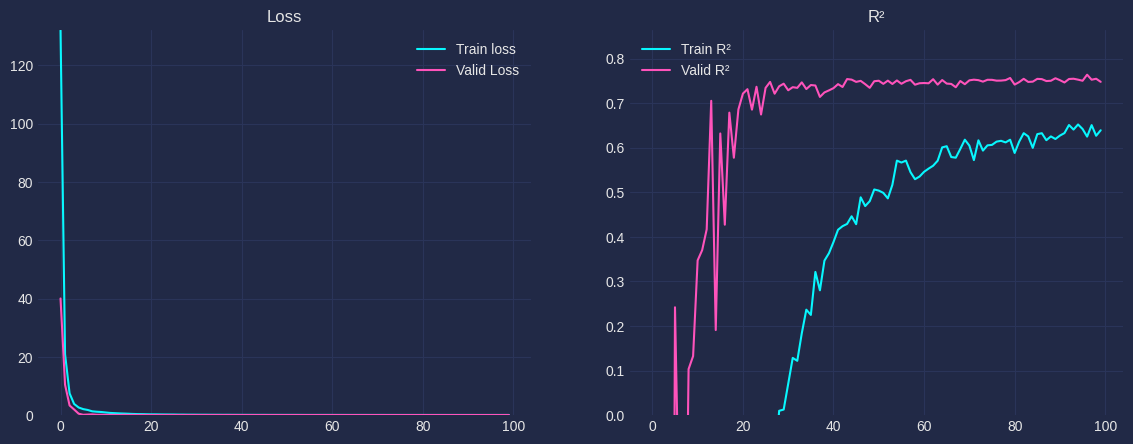

In [12]:
plot_loss_metrics(train_losses, valid_losses, train_metric, valid_metric)

6. Измени архитектуру модели и улучши результат: 
    * измени число нейронов
    * попробуй использовать сигмоидную функцию активации: `nn.Sigmoid`
    * измени число слоев
    * поэкспериментируй с активационными функциями и дропаутом

In [13]:
model = nn.Sequential(
    nn.Linear(n_features, 50),
    nn.Dropout(),
    nn.Sigmoid(),
    nn.Linear(50, 1),
    nn.ReLU()
)

In [14]:
tu.get_model_summary(model, torch.randn(90, n_features))

Layer   Kernel     Output    Params    FLOPs
0_0     [8, 50]   [90, 50]      450   67,500
1_1           -   [90, 50]        0        0
2_2           -   [90, 50]        0   18,000
3_3     [50, 1]    [90, 1]       51    8,910
4_4           -    [90, 1]        0        0
Total params: 501
Trainable params: 501
Non-trainable params: 0
Total FLOPs: 94,410 / 94.41 KFLOPs
--------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.10
Params size (MB): 0.00
Estimated Total Size (MB): 0.11


7. Попробуй добиться лучшего результата, чем получалось на прошлой неделе во время выполнения проекта!

## Дополнительное задание

### Классификация клиента банка 

* С помощью `pytorch` классифицировать клиентов банка. 

* Датасет [здесь](https://raw.githubusercontent.com/Anurion/Uralsib_test/main/Uralsib_test/Data.txt)

* Метрика: `f1_score`

* При чтении данных нужно указать аргумент `read_csv()` `encoding='kz1048'`